https://habr.com/ru/articles/799725/

https://proproprogs.ru/ml/ml-algoritm-adaboost-v-zadachah-regressii

https://proproprogs.ru/ml/ml-gradientnyy-boosting-i-stohasticheskiy-gradientnyy-boosting

https://education.yandex.ru/handbook/ml/article/gradientnyj-busting

Смысл бустинга:\
Можно без труда построить сколько угодно деревьев, дающих на обучающей выборке 100%-ю точность\
Для этого достаточно в каждой вершине выбирать для разделения любой признак и любой порог и в конце концов дерево выродится в листы в которые попадет абсолютно каждый образец обучающей выборки.\
Но важна то не точность на обучающей выборке, а степень обобщения - то есть точность на всем порождающем распределении, из которого взята обучающая выборка.

Принцип **бритвы Оккама** - Общий принцип, утверждающий, что если существует несколько логически непротиворечивых объяснений какого-либо явления, объясняющих его одинаково хорошо, то следует, при прочих равных условиях, предпочитать самое простое из них. Содержание принципа можно свести к следующему: не надо без необходимости вводить новые законы, чтобы объяснить какое-то новое явление, если это явление можно исчерпывающе объяснить старыми законами.\
Оккама требует предпочесть простое объяснение только в том случае, если оно объясняет явление не менее точно, чем сложное, учитывая весь известный на текущий момент массив наблюдений, то есть если отсутствуют объективные основания для того, чтобы предпочесть более сложное объяснение простому.\
Логически бритва Оккама базируется на принципе достаточного основания \
под термином «бритва» понимается инструмент, помогающий отбрасывать (сбривать) маловероятные, неправдоподобные объяснения.

Принцип бритвы Оккама говорит о том, что простые гипотезы предпочтительнее сложных, и попробовать построить как можно более простое дерево, которое только возможно для данного датасета.(т.е. **Оптимальное**) однако такая задача является NP-полной. \
Решение NP-полной задачи подразумевает - абсолютный перебор всех вариантов и выбор наилучшего постфактум(**Исчерпывающий поиск**).\
**Жадный поиск** - Поиск локально оптимального решения на каждом шаге(итерации), то есть решения, приводящее к наибольшему "сиюминутному" выигрышу.

----

0) Инициализируются самые первые ошибочные предсказания(**predictions**) - Как правило константной статистикой
1) Рассчитываются остатки(**residuals**) - **Антиградиент** функции потерь на **y** и **predictions**
2) Берется одно маленькое дерево решений(Глубина: 1-3, количество листьев 2-8)
3) Дерево обучается на **X** и **residuals**
4) Дерево сохраняется в ансамбль
5) Дерево делает прогноз на **X** и умножает результат на шаг обучения(**learning_rate**)
6) Полученное значенеи прибавляется к **predictions**
7) Этапы 1-5 повторяются n-раз(в зависимости от `n_estimators`)

-----
**Ансамбль - бустинг**
$$
a(x) = \sum_{i=1}^K{a_i}{b_i(x)}
$$

$$
a(x) = b_0 + a_1b_1 + a_2b_2 + ... a_kb_k
$$

$x$ - Входные данные. \
$a(x)$ - Итоговое предсказания ансамбля для входных данных $x$ \
$a_i$ - Коэффициент вклада каждой отдельной модели в итоговое предсказание (шаг обучения - learning rate) \
$b_i(x)$ - Предсказание каждой $i$-ой модели $b$-типа на входных данных $x$ \
$K$ - Количество моделей в ансамбле (n_estimators)

$b_0$ - Начальная инициализация ошибочного предсказания \
$b_k$ - k-ая модель b-типа ансамбля (weak learner - слабый ученик)

------

**Начальная инициализация ошибочного предсказания**: $b_0$

$$
b_0 = C
$$
$$
C = AVG(x),  Median(x) 
$$
$C$ - Константная статистика по входным данным  \
В качестве константы может выступать: \
- **Среднее арифметическое**(для функции потерь - MSE) \
- **Медиана**(Для функции потерь - MAE) 


*Также возможны варианты инициализации не через константу а через предсказания другой моделью*

-------

**Weak Learner**\
В бустинговом ансамбле в качестве моделей для слабых учеников выбираются модели только одного типа.\
Как правило выбираются деревья решений(**DecisionTree**) малой глубины. `max_depth`: (1-3)

-----

**Функции потерь**\
Выбираемая функция потерь должна быть дифференцируемая

**Mean Squarred Error**:
$$
MSE = \frac{1}{2}\sum_{i=1}^n{(y-y_{pred})^2}
$$
$$
gradientMSE = 2\frac{1}{2} y_{pred}-y = y_{pred}-y
$$
Для сокращения двойки **mse** берется с коэффициентом $\frac{1}{2}$\
$(a-b)^2$ = $2(b-a)$ по правилу дифференцирования.
$$
antigradientMSE = y-y_{pred}
$$


 - экспоненциальная (AdaBoost);
 - логарифмическая (LogitBoost);
 - квадратичная (GentleBoost);
 - гауссовская (BrownBoost).

# GradientBoosting

In [6]:
import numpy as np
from scipy.stats import mode
from sklearn.datasets import make_regression

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [7]:
X, y = make_regression(n_samples=100, n_features=2, n_informative=2, random_state=10)

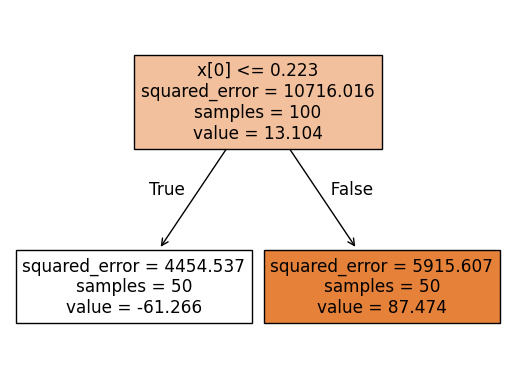

In [19]:
tree = DecisionTreeRegressor(max_depth=1) #Пень
tree.fit(X, y)
tree.predict(X)

plot_tree(tree, filled=True);

In [36]:
class GBT:
    def __init__(self, n_estimators=100, max_depth=3, min_samples=10, lr=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.residuals = []
        self.lr = lr
        self.first_leaf = None
        self.train_score = []
        
    def fit(self, X, y):
        self.first_leaf = y.mean()
        predictions = np.ones(len(y)) * self.first_leaf
        
        for i in range(self.n_estimators):
            residuals = y - predictions
            self.residuals.append(residuals)
            
            tree = DecisionTreeRegressor(max_depth = self.max_depth, min_samples_leaf = self.min_samples)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            predictions += self.lr * tree.predict(X)
            self.train_score.append(self.score(self.predict(X, len(self.trees)), y))
            
    def predict(self, X, n):           
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(n):
            predictions += self.lr * self.trees[i].predict(X)
            
        return predictions
    
    def score(self, predicted, y):
        return 1 - np.sum((predicted - y)**2) / np.sum((y.mean() - y)**2)

In [55]:
gbm = GBT(n_estimators=100, lr=0.2)
gbm.fit(X, y)
y_pred = gbm.predict(X, 100)
y_pred

array([  71.54127453,  -75.07128143,   94.94296822,  -14.95073416,
        181.15064514,  -33.04812249,  154.94534202,   14.68470736,
         13.23152539,   80.37015342,   76.83138703,   30.97018797,
         66.61963947,  -19.49741256,  140.4623195 ,  158.75322307,
        -22.98561418,  116.74142642,   77.08608241, -100.41078599,
         29.57707569, -138.37478881,  -26.49858327,   98.75618268,
        136.90624781, -135.13239835, -100.41078599,  216.14546827,
        -51.40623222, -122.85867386,    7.37252162,  -83.709722  ,
         19.98247249,  122.81543223,   86.37859603, -114.98556284,
        120.82155734,  -25.01673317,  250.06958323, -113.20426956,
       -231.23842578,   33.00216799,  161.66020723,   68.78322992,
       -142.95578851,   11.45028105,  -77.24708928,   -6.25378168,
         43.16497477,   44.75778338,  -62.31732838,   68.64209792,
       -105.74666137, -229.64734285,  250.06958323,   -6.08062614,
       -144.01754233, -143.32584752,   12.29914331,  -44.82718

In [56]:
y

array([  78.782276  ,  -70.72285027,   95.3404921 ,  -14.41467135,
        175.87172433,  -33.72683516,  150.96086808,   11.11931163,
         17.04324285,   67.27736335,   83.60715771,   35.00066742,
         67.80045162,  -16.93503431,  114.74999821,  135.46285218,
        -26.17495256,  109.54982776,   82.09154   ,  -88.97718159,
         39.80047585, -115.47216157,  -29.48749819,   89.1492031 ,
        150.81921264, -131.21851175,  -92.72710294,  237.08309066,
        -52.67110043, -130.97859828,    7.80235661,  -80.20824432,
         20.64678122,  121.01069554,   85.12971578,  -97.44468377,
        123.28949299,  -37.17768923,  261.56072887, -120.27919126,
       -258.20739496,   28.26712127,  194.23797823,   74.57300096,
       -119.46579231,   10.08931429,  -79.40355604,   -9.03360463,
         34.52376992,   43.26550213,  -64.04072235,   69.19692834,
        -88.72720901, -260.86180805,  245.56828227,   -7.48974899,
       -168.76543798, -115.77878306,   15.63289006,  -35.33566

In [57]:
from sklearn.metrics import mean_squared_error, r2_score
print('MSE: ', mean_squared_error(y, y_pred))
print('r2 score: ', r2_score(y, y_pred))

MSE:  134.2233732130173
r2 score:  0.9874745074187651


In [64]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(learning_rate=0.2, n_estimators=100, min_samples_leaf=10)
gbr.fit(X, y)
gbr.predict(X)

array([  71.54127453,  -75.07128143,   94.94296822,  -14.95073416,
        181.15064514,  -33.04812249,  154.94534202,   14.68470736,
         13.23152539,   80.37015342,   76.83138703,   30.97018797,
         66.61963947,  -19.49741256,  140.4623195 ,  158.75322307,
        -22.98561418,  116.74142642,   77.08608241, -100.41078599,
         29.57707569, -138.37478881,  -26.49858327,   98.75618268,
        136.90624781, -135.13239835, -100.41078599,  216.14546827,
        -51.40623222, -122.85867386,    7.37252162,  -83.709722  ,
         19.98247249,  122.81543223,   86.37859603, -114.98556284,
        120.82155734,  -25.01673317,  250.06958323, -113.20426956,
       -231.23842578,   33.00216799,  161.66020723,   68.78322992,
       -142.95578851,   11.45028105,  -77.24708928,   -6.25378168,
         43.16497477,   44.75778338,  -62.31732838,   68.64209792,
       -105.74666137, -229.64734285,  250.06958323,   -6.08062614,
       -144.01754233, -143.32584752,   12.29914331,  -44.82718

In [73]:
y_pred

array([  71.54127453,  -75.07128143,   94.94296822,  -14.95073416,
        181.15064514,  -33.04812249,  154.94534202,   14.68470736,
         13.23152539,   80.37015342,   76.83138703,   30.97018797,
         66.61963947,  -19.49741256,  140.4623195 ,  158.75322307,
        -22.98561418,  116.74142642,   77.08608241, -100.41078599,
         29.57707569, -138.37478881,  -26.49858327,   98.75618268,
        136.90624781, -135.13239835, -100.41078599,  216.14546827,
        -51.40623222, -122.85867386,    7.37252162,  -83.709722  ,
         19.98247249,  122.81543223,   86.37859603, -114.98556284,
        120.82155734,  -25.01673317,  250.06958323, -113.20426956,
       -231.23842578,   33.00216799,  161.66020723,   68.78322992,
       -142.95578851,   11.45028105,  -77.24708928,   -6.25378168,
         43.16497477,   44.75778338,  -62.31732838,   68.64209792,
       -105.74666137, -229.64734285,  250.06958323,   -6.08062614,
       -144.01754233, -143.32584752,   12.29914331,  -44.82718

# Sklearn

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

# XGBoost

In [3]:
import xgboost

# LightGBM

In [2]:
import lightgbm

# CatBoost

In [5]:
import catboost